# Exploring and cleaning the tweet data

### Imports

In [404]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import emoji
import pickle


### Reading in Data

In [405]:
data = pd.read_csv('../Protected/Data/corpus_with_text.csv')

In [406]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8379 entries, 0 to 8378
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   8379 non-null   int64 
 1   text    8379 non-null   object
dtypes: int64(1), object(1)
memory usage: 131.0+ KB


### Tokenizing and Lemmatizing

In [407]:
def tok_and_lem(dataframe, new_column, input_column,handles = True, tok = True, lem = True):
    tokenizer = TweetTokenizer(strip_handles = handles)
    lemmatizer = WordNetLemmatizer()
    #tokenizing
    dataframe[new_column] = [tokenizer.tokenize(row) for row in dataframe[input_column]]
    #lemmatizing and joining the text back together 
    for row in dataframe.index:
        dataframe[new_column].iloc[row] = ' '.join([lemmatizer.lemmatize(word) for word in dataframe[new_column][row]])
    #example of what the data looks like
    return dataframe[new_column]

In [408]:
tok_and_lem(data,'text_processed','text')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0       plz excuse me while I cry . I DONT even know w...
1       you had me til the goat cheese ... What's next...
2       Either way , I should go get a flu shot . And ...
3       and form them into something we like yep make ...
4                                         thanks mate ...
                              ...                        
8374    You don't . I have purchased a lot on Amazon (...
8375    #Emotions you say 🤔 never knew that I think I ...
8376    You are so right ... " Yes ! #Silence is not #...
8377    Another lazy delusional voter who take the wor...
8378    I hope you know no news outlet from Nigeria ha...
Name: text_processed, Length: 8379, dtype: object

## Exploring Emoji use

In [409]:
#First, using the emoji library I'll collect a list of all unique emojis in the corpus
emoji_list=[]
for row in data['text']:
    for c in row:
        if c in emoji.UNICODE_EMOJI:
            emoji_list.append(c)
emoji_set =  list(set(emoji_list))
emoji_dict = {str(c):emoji_list.count(c) for c in emoji_set}
print(f'Number of unique emojis used:{len(emoji_set)}')
print(f'Number of emojis used overall: {len(emoji_list)}')

print(emoji_set[0:10])

Number of unique emojis used:336
Number of emojis used overall: 2529
['🤪', '💞', '🍽', '🇿', '📺', '🤦', '🍫', '😉', '😳', '✊']


In [410]:
emoji_dataframe = pd.DataFrame(emoji_dict.values(), index = emoji_dict.keys(), columns = ['Emoji Count'])
emoji_dataframe.sort_values(by = 'Emoji Count', ascending = False)[0:15]

,Emoji Count
😂,233
🤣,139
❤,120
🙏,75
👍,59
😉,52
😊,45
🙄,45
😘,42
🤔,37


<BarContainer object of 15 artists>

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128158 missing 

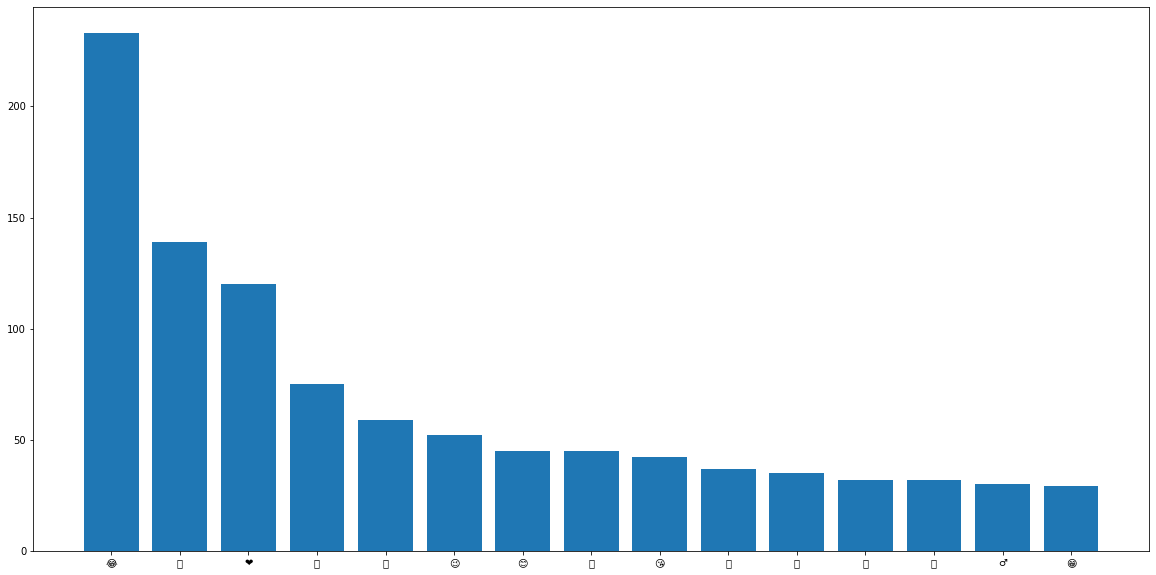

In [411]:
plt.figure(figsize = (20,10))
plt.bar(x = emoji_dataframe.sort_values(by = 'Emoji Count', ascending = False)[0:15].index, height = emoji_dataframe.sort_values(by = 'Emoji Count', ascending = False)[0:15]['Emoji Count'])

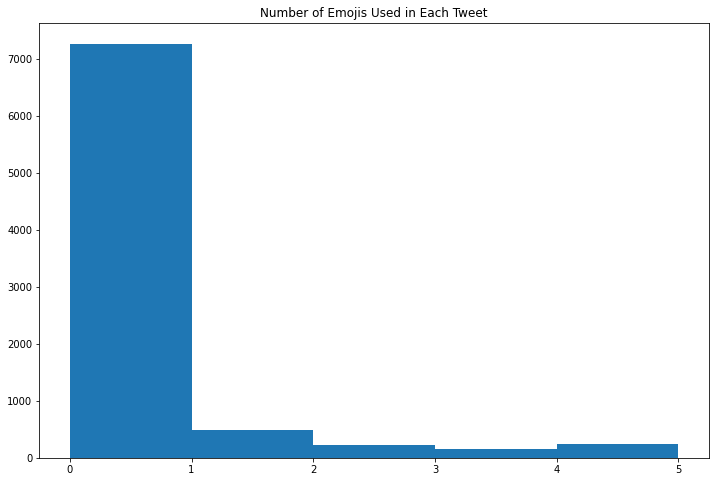

In [412]:
#using the emoji_list to identify and count the emojis in each tweet
def is_emoji(s):
    emojis = emoji_set # add more emojis here
    count = 0
    for emoji in emojis:
        count += s.count(emoji)
    return count

data['emojis_used'] = data['text_processed'].apply(is_emoji)
plt.figure(figsize = (12,8))
plt.hist(pd.DataFrame(data['emojis_used']), bins = range(0,6))
plt.title("Number of Emojis Used in Each Tweet");
plt.savefig('../Images/Number_of_emojis_used_per_tweet.png')

In [413]:
#How many tweets in each class use emojis?
pd.DataFrame(data.groupby(data['label'])['emojis_used'].value_counts(normalize = True))

emojis_used
label emojis_used             
0     0               0.829117
      1               0.067324
      2               0.037307
      5               0.030875
      3               0.023799
      4               0.011578
1     0               0.916016
      1               0.046299
      2               0.014805
      3               0.012113
      4               0.005922
      5               0.004845

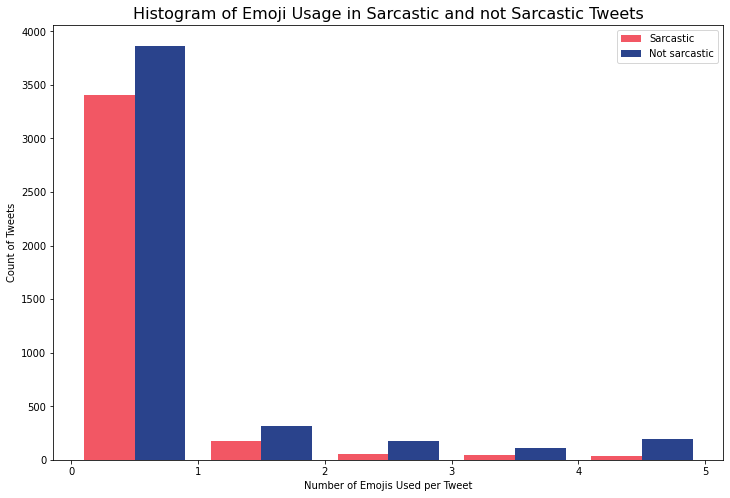

In [414]:
# Let's see how emoji usage relates to the labeling of sarcastic or not
plt.figure(figsize = (12,8))
plt.hist([data.loc[data['label']==1]['emojis_used'], data.loc[data['label']==0]['emojis_used']], bins = [0,1,2,3,4,5], color = ['#f25764','#2a438c'])
plt.legend(labels = ['Sarcastic','Not sarcastic'])
plt.title('Histogram of Emoji Usage in Sarcastic and not Sarcastic Tweets', size = 16);
plt.xlabel("Number of Emojis Used per Tweet")
plt.ylabel('Count of Tweets')
plt.savefig("../Images/histogram_of_emoji_usage.png")

In [415]:
def pull_emojis(column):
    emoji_list = [c for c in column if c in emoji.UNICODE_EMOJI]
    
    return emoji_list
data['emojis_used_in_text'] = data['text_processed'].apply(pull_emojis)

In [416]:
#It doesn't look like there is much of a relationship between number of emojis and the positive class
data[['label','emojis_used']].corr()

,label,emojis_used
label,1.000000,-0.135016
emojis_used,-0.135016,1.000000


## Sentiment Analysis exploration

In [417]:
sentiment = SentimentIntensityAnalyzer()

data['neg_sentiment'] = [sentiment.polarity_scores(row)['neg'] for row in data['text']]
data['pos_sentiment'] = [sentiment.polarity_scores(row)['pos'] for row in data['text']]
data['neu_sentiment'] = [sentiment.polarity_scores(row)['neu'] for row in data['text']]
data['comp_sentiment'] = [sentiment.polarity_scores(row)['compound'] for row in data['text']]

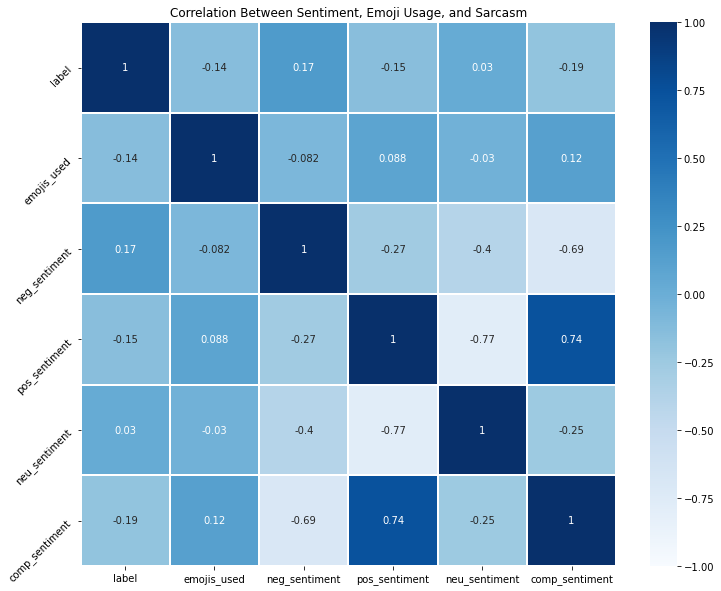

In [418]:
#heatmap of the correlation between features. 
plt.figure(figsize = (12,10))
sns.heatmap(data.corr(), vmin = -1, vmax = 1, annot = True, cmap = "Blues", linewidths = 1)
plt.title("Correlation Between Sentiment, Emoji Usage, and Sarcasm")
plt.yticks(rotation = 45)

plt.savefig("../Images/sentiment_heatmap.png")

In [419]:
data.drop(columns = ['text']).head()

,label,text_processed,emojis_used,emojis_used_in_text,neg_sentiment,pos_sentiment,neu_sentiment,comp_sentiment
0,1,plz excuse me while I cry . I DONT even know w...,0,[],0.110,0.248,0.641,0.4336
1,1,you had me til the goat cheese ... What's next...,3,"[🐐, 🐐, 🐐]",0.000,0.000,1.000,0.0000
2,1,"Either way , I should go get a flu shot . And ...",0,[],0.157,0.000,0.843,-0.3818
3,1,and form them into something we like yep make ...,0,[],0.135,0.276,0.588,0.3400
4,1,thanks mate ...,0,[],0.000,0.592,0.408,0.4404


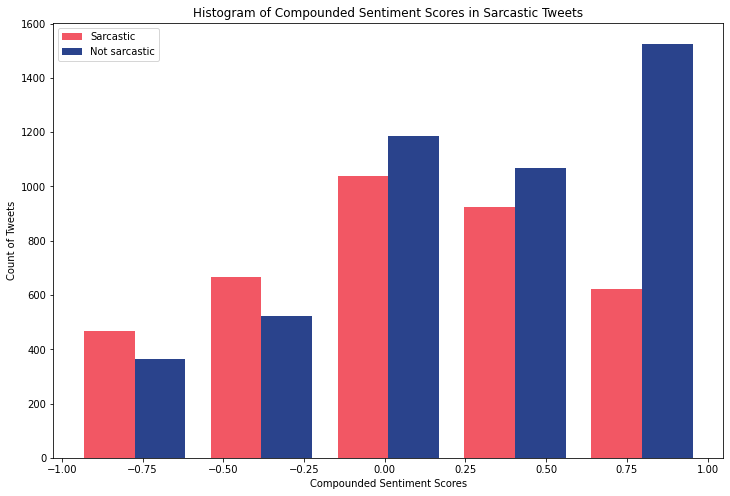

In [420]:
# Let's see how sentiment  relates to the labeling of sarcastic or not
plt.figure(figsize = (12,8))
plt.hist([data.loc[data['label']==1]['comp_sentiment'],data.loc[data['label']==0]['comp_sentiment']], color = ['#f25764','#2a438c'], bins = 5)
plt.legend(labels = ['Sarcastic','Not sarcastic'])
plt.xlabel('Compounded Sentiment Scores')
plt.ylabel('Count of Tweets')
plt.title('Histogram of Compounded Sentiment Scores in Sarcastic Tweets');
plt.savefig('../Images/sentiment_histogram.png')

In [421]:
#are the positive and negative tweets actually different sentimentally? 
tt = stats.ttest_ind(data['comp_sentiment'].loc[data['label'] == 1], data['comp_sentiment'].loc[data['label'] == 0], equal_var=False)
tt
#p value indicates that we can reject the null hypothesis that the two groups have the same mean

Ttest_indResult(statistic=-17.573456779344856, pvalue=7.192538195933798e-68)

In [422]:
data.groupby(by = data['comp_sentiment'] >= 0)['label'].agg("count")

comp_sentiment
False    2399
True     5980
Name: label, dtype: int64

In [423]:
data.to_csv('../Protected/Data/corpus_processed.csv', index = False)

In [424]:
#Functions can be used to take an input string and predict the presence of sarcasm
def tok_and_lem_input(handles = True, tok = True, lem = True, predict = True):
    tweet = input("What is the tweet you'd like to post?")
    input_dict = {0:tweet}
    dataframe = pd.DataFrame(input_dict, index = input_dict.keys())
    tokenizer = TweetTokenizer(strip_handles = handles)
    lemmatizer = WordNetLemmatizer()
    #tokenizing
    dataframe['text_processed'] = [tokenizer.tokenize(row) for row in dataframe[0]]
    #lemmatizing and joining the text back together 
    for row in dataframe.index:
        dataframe['text_processed'].iloc[row] = ' '.join([lemmatizer.lemmatize(word) for word in dataframe['text_processed'][row]])
    #example of what the data looks like
    if predict == False:
        return dataframe['text_processed']
    if predict == True:
        return predict_sarcasm(dataframe['text_processed'])

def predict_sarcasm(values):
    model = pickle.load(open('./../Models/n_bayes_2','rb'))
    preds = model.predict(values)
    if preds == 1:
        return "That sounds Sarcastic"
    if preds == 0:
        return "That doesn't sound Sarcastic"
    else:
        return "oops something went wrong"


## Additional word vector investigation

In [425]:
#using the 
cv = CountVectorizer(max_df = .85,min_df = 2, ngram_range = (1,2), stop_words = 'english')
cv.fit_transform(data['text_processed'])

<8379x13529 sparse matrix of type '<class 'numpy.int64'>'
	with 85725 stored elements in Compressed Sparse Row format>

In [426]:
tf_df_sarcasm = pd.DataFrame(cv.transform(data['text_processed'].loc[data['label']==1]).todense(), columns = cv.get_feature_names())
tf_df_no_sarcasm = pd.DataFrame(cv.transform(data['text_processed'].loc[data['label']==0]).todense(), columns = cv.get_feature_names())

<AxesSubplot:>

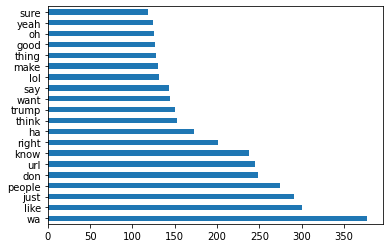

In [427]:
tf_df_sarcasm.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')


<AxesSubplot:>

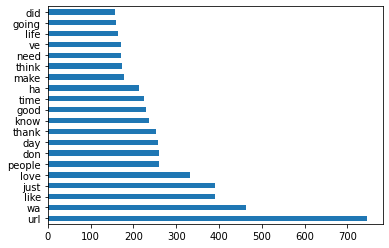

In [428]:
tf_df_no_sarcasm.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')


In [429]:
col_list = [col for col in list(tf_df_sarcasm.columns) if tf_df_no_sarcasm[col].sum() < 1]

In [430]:
tf_df_sarcasm.sum().sort_values()

00                0
loaded thank      0
loaded            0
lmao banking      0
ll try            0
               ... 
don             248
people          274
just            291
like            300
wa              377
Length: 13529, dtype: int64